# Frequency analysis and sentiment with NLTK

find_word_freq_readfiles.ipynb

### 1 ###
•	It reads the dataframe with the analysis (file_df_analysis) and the dataframe with the histogram (file_df_analysis_hist) information created by “analyse_papers.ipynb”
•	Frequency analysis of the sentence were a paper was cited. It finds a representative sentence showing how the a paper has been cited in the different sections. It is selected by getting the list of sentences containing the maximum number of most frequent words used when citing the paper (in each section). If there are several sentences it picks the shortest one.

### 2 ###
•	Sentiment analysis using NLTK.



##############################################################


### 1 ###
•	It reads the dataframe with the analysis (file_df_analysis) and the dataframe with the histogram (file_df_analysis_hist) information created by “analyse_papers.ipynb”
•	Frequency analysis of the sentence were a paper was cited. It finds a representative sentence showing how the a paper has been cited in the different sections. It is selected by getting the list of sentences containing the maximum number of most frequent words used when citing the paper (in each section). If there are several sentences it picks the shortest one.


In [1]:
%matplotlib inline

In [2]:
import sys
import os
import re
from copy import deepcopy
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

sys.path.insert(0, "./modules")
import words_frec_analysis_get_sentence

# Configuration

In [3]:
data_path = 'data'

ds_name = 'DOI_cited_science_1179052_retracted'

analysis_path = os.path.join(data_path, 'analysis')

# In
citing_sections_tsv = os.path.join(analysis_path, '%s_sections.tsv' % ds_name)
analysis_hist_tsv = os.path.join(analysis_path, '%s_hist_v2.tsv' % ds_name)

# Setup

In [4]:
# One time download
nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/deuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/deuser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Analysis

In [5]:
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')
df.head()

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_number,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
0,10.1126/science.1179052,False,False,False,False,10.1186/1477-7525-12-64,True,True,True,True,B50,NaN,NaN,NaN,NaN
1,10.1126/science.1179052,False,True,False,True,10.1186/1479-5876-8-1,True,True,True,True,B47,NaN,['These deficiencies in NK activity may increa...,NaN,['These deficiencies in NK activity may increa...
2,10.1126/science.1179052,False,True,True,True,10.1186/1479-5876-7-96,True,True,True,True,B13,NaN,['Both cell associated and cell-free transmiss...,['These observations have led to reports of as...,['Both cell associated and cell-free transmiss...
3,10.1126/science.1179052,False,False,False,False,DOI not found,False,False,False,True,B7,NaN,NaN,NaN,NaN
4,10.1126/science.1179052,False,False,False,True,10.1186/2040-2392-1-14,False,False,False,True,B5,NaN,NaN,NaN,"['More recently, Lombardi,<italic>et al</itali..."


In [6]:
df_hist = pd.read_csv(analysis_hist_tsv, sep='\t', encoding='utf-8')
df_hist.head()

,DOI_cited,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,papers_all_sections_found,total_papers_citing
0,10.1126/science.1179052,0.121212,0.424242,0.636364,0.666667,33,43


In [7]:
df[df['cited_DOI'] == df_hist.iloc[0].DOI_cited]

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_number,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
0,10.1126/science.1179052,False,False,False,False,10.1186/1477-7525-12-64,True,True,True,True,B50,NaN,NaN,NaN,NaN
1,10.1126/science.1179052,False,True,False,True,10.1186/1479-5876-8-1,True,True,True,True,B47,NaN,['These deficiencies in NK activity may increa...,NaN,['These deficiencies in NK activity may increa...
2,10.1126/science.1179052,False,True,True,True,10.1186/1479-5876-7-96,True,True,True,True,B13,NaN,['Both cell associated and cell-free transmiss...,['These observations have led to reports of as...,['Both cell associated and cell-free transmiss...
3,10.1126/science.1179052,False,False,False,False,DOI not found,False,False,False,True,B7,NaN,NaN,NaN,NaN
4,10.1126/science.1179052,False,False,False,True,10.1186/2040-2392-1-14,False,False,False,True,B5,NaN,NaN,NaN,"['More recently, Lombardi,<italic>et al</itali..."
5,10.1126/science.1179052,False,False,False,True,10.1186/1743-7075-7-79,True,False,True,True,B30,NaN,NaN,NaN,['reported finding a gammaretrovirus in periph...
6,10.1126/science.1179052,False,False,False,False,DOI not found,False,False,False,True,B2,NaN,NaN,NaN,NaN
7,10.1126/science.1179052,False,False,True,True,10.1371/journal.pone.0027870,False,True,True,True,pone.0027870-Lombardi1,NaN,NaN,"['In 2009, Lombardi<italic>et al.</italic>repo...",['For amplification of XMRV/MLV<italic>gag</it...
8,10.1126/science.1179052,False,False,False,True,10.3201/eid1702.100978,False,False,False,True,R2,NaN,NaN,NaN,"['Avenida de Córdoba sn, Madrid 28041, Spain; ..."
9,10.1126/science.1179052,True,False,False,True,10.3201/eid1606.100066,True,False,False,True,R5,"['<sec sec-type=""other2""><title>Conclusions</t...",NaN,NaN,['Recent findings of XMRV sequences in up to 6...


In [8]:
df_filtered = df['sentence_citing_maintext'].dropna()

df_filtered

1     ['These deficiencies in NK activity may increa...
2     ['Both cell associated and cell-free transmiss...
4     ['More recently, Lombardi,<italic>et al</itali...
5     ['reported finding a gammaretrovirus in periph...
7     ['For amplification of XMRV/MLV<italic>gag</it...
8     ['Avenida de Córdoba sn, Madrid 28041, Spain; ...
9     ['Recent findings of XMRV sequences in up to 6...
10    ['RD-114 is expressed by all species of the ge...
11    ['[<xref ref-type="bibr" rid="B8">8</xref>] (T...
12    ['More recently, XMRV has also been found, wit...
13    ['In 2009, a high incidence of XMRV infection ...
15    ['Remarkably, the 22Rv1 sequences displayed av...
16    ['<html><body><p>c&gt;<sec><title>Results and ...
17    ['Plasma samples of CFS patients were simultan...
20    ['In addition, we collected 37 blood samples (...
21    ['Thus there was no linkage between viral DNA ...
22    ['Hamster Lec8 cells have a glycosylation defe...
25    ['reported finding XMRV in 67% of persons 

In [9]:
was_intro_found = df['introduction_found'] == True
df_filtered = df[was_intro_found]
print(df_filtered.shape)
df_filtered

(31, 15)


,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_number,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
0,10.1126/science.1179052,False,False,False,False,10.1186/1477-7525-12-64,True,True,True,True,B50,NaN,NaN,NaN,NaN
1,10.1126/science.1179052,False,True,False,True,10.1186/1479-5876-8-1,True,True,True,True,B47,NaN,['These deficiencies in NK activity may increa...,NaN,['These deficiencies in NK activity may increa...
2,10.1126/science.1179052,False,True,True,True,10.1186/1479-5876-7-96,True,True,True,True,B13,NaN,['Both cell associated and cell-free transmiss...,['These observations have led to reports of as...,['Both cell associated and cell-free transmiss...
5,10.1126/science.1179052,False,False,False,True,10.1186/1743-7075-7-79,True,False,True,True,B30,NaN,NaN,NaN,['reported finding a gammaretrovirus in periph...
7,10.1126/science.1179052,False,False,True,True,10.1371/journal.pone.0027870,False,True,True,True,pone.0027870-Lombardi1,NaN,NaN,"['In 2009, Lombardi<italic>et al.</italic>repo...",['For amplification of XMRV/MLV<italic>gag</it...
10,10.1126/science.1179052,False,False,True,True,10.3389/fmicb.2010.00147,True,False,True,True,B41,NaN,NaN,['XMRV infection still lacks a firm disease as...,['RD-114 is expressed by all species of the ge...
11,10.1126/science.1179052,False,True,True,True,10.1186/1742-4690-7-10,True,True,True,True,B8,NaN,"['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] co...","['More recently, additional groups of samples ...","['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] (T..."
14,10.1126/science.1179052,False,False,True,False,10.1186/1742-4690-7-70,True,True,True,True,B15,NaN,NaN,"['Importantly, the chromosomal locations of XM...",NaN
15,10.1126/science.1179052,True,False,True,True,10.1186/1742-4690-7-112,True,False,True,True,B3,['Additional findings from the Hué study sugge...,NaN,['<sec><title>Introduction</title><p>Reports o...,"['Remarkably, the 22Rv1 sequences displayed av..."
16,10.1126/science.1179052,False,True,True,True,10.1186/1742-4690-7-111,True,True,True,True,B2,NaN,['<sec><title>Results and Discussion</title><s...,['XMRV has also been detected in 1-6% of healt...,['<html><body><p>c&gt;<sec><title>Results and ...


In [10]:
df_filtered.drop('sentence_citing_intro', axis=1, inplace=False).describe()

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_number,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_maintext
count,31,31,31,31,31,31,31,31,31,31,31,3,13,20
unique,1,2,2,2,2,31,2,2,1,1,20,3,13,20
top,10.1126/science.1179052,False,False,True,True,10.1186/1742-4690-7-113,True,True,True,True,B3,['This report of the possible contribution of ...,['Several studies have reported detection of r...,['Several studies have reported detection of r...
freq,31,28,18,21,20,1,27,24,31,31,4,1,1,1


#### Let's find the most frequente words in an example of a representative sentence for each section (intro, discussion, etc) where the paper is cited.

In [11]:
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')
#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']


print('cited_DOI: ', df.cited_DOI.unique())


print("\n------------- ANALYSIS INTRODUCTION -----------")
sentences_intro = df.sentence_citing_intro.dropna()
if not sentences_intro.empty:
    words_frec_analysis_get_sentence.analysis(sentences_intro)
else:
    print("No sentences to analyse")

print("\n------------- ANALYSIS MAINTEXT -----------")
sentences_maintext = df.sentence_citing_maintext.dropna()
if not sentences_maintext.empty:
    words_frec_analysis_get_sentence.analysis(sentences_maintext)
else:
    print("No sentences to analyse")

print("\n------------- ANALYSIS DISCUSSION -----------")
sentences_discussion = df.sentence_citing_discussion.dropna()
if not sentences_discussion.empty:
    words_frec_analysis_get_sentence.analysis(sentences_discussion)
else:
    print("No sentences to analyse")
    
    
print("\n ------------- ANALYSIS CONCLUSIONS -----------")
#number_features = 5
sentences_conclusions = df.sentence_citing_conclusions.dropna()
if not sentences_conclusions.empty:
    words_frec_analysis_get_sentence.analysis(sentences_conclusions)
else:
    print("No sentences to analyse")    


cited_DOI:  ['10.1126/science.1179052']

------------- ANALYSIS INTRODUCTION -----------
2                                                ,-].']
7     reported dection XMRV peripherblood mononuclea...
10    ), respiratory tract patients without respirat...
11    ] negative ,] results.Very recently, paper rep...
14    vivo,].Following discovery XMRV prostate tumor...
15    Reports newly-discovered gammarrovirus (xenotr...
16                                               ,,].']
17    Xenotropic murine leukemia virus-related virus...
18                                                 ].']
19                                                 ].']
20                                                 ].']
23    -], however repeated cohorts -].XMRV reported ...
24    ], dected XMRV chronic fatigue syndrome (CFS) ...
28    reported finding gammarrovirus ced xenotropic ...
29                                                 ].']
30    Xenotropic Murine leukemia virus-Related Virus...
31    ] found %


 ------------- ANALYSIS CONCLUSIONS -----------
9     XMRV, originy identified RNase L–deficient pat...
15    ,] derived copies virus present Rv cells, like...
35                                                ,].']
38    ] source controversy significance specificity ...
Name: sentence_citing_conclusions, dtype: object
['cancer', 'cells', 'chronic', 'patients', 'xmrv']
Frequent words included:  [7, 3, 0, 2]
Maximum words in the same sentence  =  7
9,"['<sec sec-type=""other2""><title>Conclusions</title><p>XMRV, originally identified in RNase L–deficient patients with familial prostate cancer, has gained interest since recent work showed its protein expression in as many as 23% of prostate cancer cases (<xref ref-type=""bibr"" rid=""R10""><italic>10</italic></xref>) and XMRV-specific sequences were detected in PBMCs of 67% patients with chronic fatigue syndrome (<xref ref-type=""bibr"" rid=""R5""><italic>5</italic></xref>).']"


### 2 ###
•	Sentiment analysis using NLTK.

In [12]:
stopwords = nltk.corpus.stopwords

def filter_sentence(citing_sentence):
    if citing_sentence == None:
        return " " #filtered_sentences_noNone.append(" ")
    
    if citing_sentence != None:
        citing_sentence = re.sub("[\<\[].*?[\>\]]", "", citing_sentence) #to remove citations
        #citing_sentence = re.sub("[*?]", "", citing_sentence) #to remove citations
        citing_sentence = re.sub('[0-9]+', '', citing_sentence)
        delete = ["Introduction", "Background", "Conclusions","the", "and", "therefore", "thus"]#, "\n", "<\sub>", "bibr", "ref", "rid", "type", "xref"] #, "/p\np\n", "\p"]
        for word in delete:
            citing_sentence = re.sub(word, "", citing_sentence) 
        #citing_sentence = re.sub("\?", "", citing_sentence) #to remove citations
        citing_sentence = ' '.join([word for word in citing_sentence.split() if word not in (stopwords.words('english'))])
        return citing_sentence # O ?????????filtered_sentences_noNone.append(sentence[0])

def fit_transform_or_empty(vectorizer, data):
    return count_vectorizer.fit_transform(data) if len(data) > 0 else csr_matrix([])

#file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')

#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']
    


count_vectorizer = CountVectorizer(max_features=5)
#sentence = ''.join(str(string) for string in citing_sentences_list)
#sentence = sentence.decode('utf-8')
#u_sentence = unicode( sentence, "utf-8" )
#backToBytes = u_sentence.encode( "utf-8" )



#sentence = re.sub(r',([0-9])', '\\1', sentence)
# sort out HMTL formatting of &
#sentence = re.sub(r'&amp', 'and', sentence)

citing_sentences_intro_list = df.sentence_citing_intro.dropna()
citing_sentences_maintext_list = df.sentence_citing_maintext.dropna()
citing_sentences_discussion_list = df.sentence_citing_discussion.dropna()
citing_sentences_conclusions_list = df.sentence_citing_conclusions.dropna()
    
citing_sentences_original_intro = deepcopy(citing_sentences_intro_list)
citing_sentences_original_maintext = deepcopy(citing_sentences_maintext_list)
citing_sentences_original_discussion = deepcopy(citing_sentences_discussion_list)
citing_sentences_original_conclusions = deepcopy(citing_sentences_conclusions_list) # This is a list of lists, so you need deepcopy

filtered_sentences_intro_list = citing_sentences_intro_list.apply(filter_sentence)
filtered_sentences_maintext_list = citing_sentences_maintext_list.apply(filter_sentence)
filtered_sentences_discussion_list = citing_sentences_discussion_list.apply(filter_sentence)
filtered_sentences_conclusions_list = citing_sentences_conclusions_list.apply(filter_sentence)        

#filtered_sentences_intro_list = [filter_sentence(sentence) for sentence in citing_sentences_intro_list]
#filtered_sentences_maintext_list = [filter_sentence(sentence) for sentence in citing_sentences_maintext_list]
#filtered_sentences_discussion_list = [filter_sentence(sentence) for sentence in citing_sentences_discussion_list]
#filtered_sentences_conclusions_list = [filter_sentence(sentence) for sentence in citing_sentences_conclusions_list]

print(filtered_sentences_intro_list)
#citing_sentences_intro_list.apply(filter_sentence)

count_vectors_intro = fit_transform_or_empty(count_vectorizer, filtered_sentences_intro_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_intro = count_vectors_intro.toarray()

count_vectors_maintext = fit_transform_or_empty(count_vectorizer, filtered_sentences_maintext_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_maintext = count_vectors_maintext.toarray()

count_vectors_discussion = fit_transform_or_empty(count_vectorizer, filtered_sentences_discussion_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_discussion = count_vectors_discussion.toarray()

count_vectors_conclusions = fit_transform_or_empty(count_vectorizer, filtered_sentences_conclusions_list)
#print(count_vectorizer.get_feature_names())
#word_frequency_conclusions = count_vectors_conclusions.toarray()


#print(word_frequency_intro)
#print(word_frequency_maintext)
#print(word_frequency_discussion)
#print(word_frequency_conclusions)

number_words_in_sentence_intro = np.sum(count_vectors_intro.toarray(),axis=1).tolist()
number_words_in_sentence_maintext = np.sum(count_vectors_maintext.toarray(),axis=1).tolist()
number_words_in_sentence_discussion = np.sum(count_vectors_discussion.toarray(),axis=1).tolist()
number_words_in_sentence_conclusions = np.sum(count_vectors_conclusions.toarray(),axis=1).tolist()



print("Frequent words included (intro): ", number_words_in_sentence_intro)
print("Frequent words included (maintext): ", number_words_in_sentence_maintext)
print("Frequent words included (discussion): ", number_words_in_sentence_discussion)
print("Frequent words included (conclusions): ", number_words_in_sentence_conclusions)

print("maximum words in the same sentence in introduction =", max(number_words_in_sentence_intro))
print("maximum words in the same sentence in maintext =", max(number_words_in_sentence_maintext))
print("maximum words in the same sentence in discussion =", max(number_words_in_sentence_discussion))
print("maximum words in the same sentence in conclusions =", max(number_words_in_sentence_conclusions))

"""
df_sentences_intro = pd.DataFrame({"citing_intro_sentence" : filtered_sentences_intro_list, 
                                 "number_frequent_words" : number_words_in_sentence_intro})
"""
# length of sentence

sentence_length_intro = []
for sentence in citing_sentences_intro_list:
    if sentence == None:
        sentence_length_intro.append(0)
    if sentence != None:
        sentence_length_intro.append(len(sentence))

df_sentences_intro = pd.DataFrame({"frequent_words" : number_words_in_sentence_intro,
                                "citing_sentence" : citing_sentences_original_intro,
                                "sentence_length": sentence_length_intro})


sentences_toCheck = df_sentences_intro[(df_sentences_intro["frequent_words"] == max(df_sentences_intro["frequent_words"]))] #['sentence_citing_intro']
min_length= min(sentences_toCheck["sentence_length"][:])
print("min_length: ", min_length)

sentence = sentences_toCheck[sentences_toCheck['sentence_length'] == min_length]["citing_sentence"]

# To print the full content
sentence.to_csv(sys.stdout)

2                                                ,-].']
7     et al.reported detection XMRV peripheral blood...
10    ), respiratory tract patients without respirat...
11    ] negative ,] results.Very recently, paper rep...
14    vivo,].Following discovery XMRV prostate tumor...
15    Reports newly-discovered gammaretrovirus (xeno...
16                                               ,,].']
17    Xenotropic murine leukemia virus-related virus...
18                                                 ].']
19                                                 ].']
20                                                 ].']
23    -], however repeated cohorts -].XMRV also repo...
24    ], detected XMRV chronic fatigue syndrome (CFS...
28    et al.reported finding gammaretrovirus called ...
29                                                 ].']
30    Xenotropic Murine leukemia virus-Related Virus...
31    ] found % (/) patients CFS carried detectable ...
33    ] first reported presence xenotropic murin

In [13]:
df = pd.read_csv(citing_sections_tsv, sep='\t', encoding='utf-8')

citing_sentences_intro= df['sentence_citing_maintext']
citing_sentences_intro_list = citing_sentences_intro.tolist()
print(citing_sentences_intro_list[1])

count_vectorizer = CountVectorizer(max_features=5)
#sentence = ''.join(str(string) for string in citing_sentences_list)
#sentence = sentence.decode('utf-8')
#u_sentence = unicode( sentence, "utf-8" )
#backToBytes = u_sentence.encode( "utf-8" )



#sentence = re.sub(r',([0-9])', '\\1', sentence)
# sort out HMTL formatting of &
#sentence = re.sub(r'&amp', 'and', sentence)

# If you want to avoid to go through all the papers, you can select those with introductions by
# by replacing citing_sentences_intro_list by df_intro_filtered.tolist()


citing_sentences_original = deepcopy(citing_sentences_intro_list) # This is a list of lists, so you need deepcopy
#print(citing_sentences_original[19])
filtered_sentences_noNone = []
filtered_sentences = citing_sentences_intro_list[:]
print(filtered_sentences[0:1])
for sentence in filtered_sentences:
    if (type(sentence) == float):
        filtered_sentences_noNone.append(" ")
    if (type(sentence) != float):
        #print("######################### ", type(sentence), sentence)
        delete = ["Introduction", "Background", "the", "and"]
        for word in delete:
            sentence = re.sub(word, "", sentence) 
        sentence = re.sub("[\<\[].*?[\>\]]", "", sentence) #to remove cititations
        sentence = ' '.join([word for word in sentence.split() if word not in (stopwords.words('english'))])
        filtered_sentences_noNone.append(sentence)

count_vectorizer.fit_transform(filtered_sentences_noNone) #backToBytes
#print(citing_sentences_original[19]) 
    
print(count_vectorizer.get_feature_names())
count_vectors = count_vectorizer.transform(filtered_sentences_noNone)

word_frequency = count_vectors.toarray()
print(word_frequency)
number_words_in_sentence = np.sum(count_vectors.toarray(),axis=1).tolist()

print("Frequent words included: ", number_words_in_sentence)


#print(citing_sentences_intro_list)
print("maximum words in the same sentence =", max(number_words_in_sentence))

#df_introCiting = pd.DataFrame({"citing_intro_sentence" : filtered_sentences_noNone, 
#                                "number_frequent_words" : number_words_in_sentence})
#print(df_introCiting)

# length of sentence
sentence_length = []
for sentence in citing_sentences_intro_list:
    if (sentence == None) | (sentence == np.nan):
        sentence_length.append(0)
    if (sentence != None) & (sentence != np.nan):
        sentence_length.append(len(str(sentence)))



df_introCiting = pd.DataFrame({"frequent_words" : number_words_in_sentence,
                                "citing_sentence" : citing_sentences_original,
                                "sentence_length": sentence_length})


sentences_toCheck = df_introCiting[(df_introCiting["frequent_words"] == max(df_introCiting["frequent_words"]))] #['sentence_citing_intro']
min_length= min(sentences_toCheck["sentence_length"][:])

sentence = sentences_toCheck[sentences_toCheck['sentence_length'] == min_length]["citing_sentence"]

# To print the full content
sentence.to_csv(sys.stdout)

['These deficiencies in NK activity may increase viral load in CFS, incidentally a recent study observed increases in xenotropic murine leukemia virus-related virus (XMRV) in peripheral blood samples of CFS patients [<xref ref-type="bibr" rid="B47">47</xref>].']
[nan]
['cfs', 'patients', 'pcr', 'samples', 'xmrv']
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 1 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 1]
 [0 0 0 0 0]
 [0 1 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 2 0 0 0]
 [0 0 1 0 3]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 0 3]
 [1 1 3 5 1]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 2]
 [0 0 0 0 1]
 [1 0 0 0 2]
 [1 0 0 1 1]
 [0 1 1 2 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Frequent words included:  [0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 2, 4, 0, 0, 0, 6, 11, 1, 0, 0, 0, 3, 0, 0, 0, 2, 1, 3

In [14]:
sid = SentimentIntensityAnalyzer()


df_sentiment = df_introCiting.copy()
#ss = sid.polarity_scores(df_sentiment['citing_sentence'][4][0]) #if None => error
#print(ss)

df_sentiment2 = filtered_sentences_noNone
#ss2 = sid.polarity_scores(df_sentiment2[2])
ss2 = sid.polarity_scores(df_sentiment2[0])

sentiment_scores_list = []
for sentence in df_sentiment2:
    ss2 = sid.polarity_scores(sentence) # from twython  package
    sentiment_scores_list.append(ss2)
df_sentiment_scores = pd.DataFrame(sentiment_scores_list)

    #df_sentiment_scores.append(ss2)
#df_sentiment2


df_sentiment = df_sentiment.join(df_sentiment_scores)

df_sentiment

# for i, tweet in df_sentiment['text'].iteritems():
#     ss = sid.polarity_scores(str(tweet))
#     for k in sorted(ss):
#         df_sentiment.loc[i, k] = ss[k]

,citing_sentence,frequent_words,sentence_length,compound,neg,neu,pos
0,NaN,0,3,0.0000,0.000,0.000,0.000
1,['These deficiencies in NK activity may increa...,0,262,0.0000,0.000,1.000,0.000
2,['Both cell associated and cell-free transmiss...,0,181,0.0000,0.000,1.000,0.000
3,NaN,0,3,0.0000,0.000,0.000,0.000
4,"['More recently, Lombardi,<italic>et al</itali...",3,229,0.3818,0.114,0.682,0.205
5,['reported finding a gammaretrovirus in periph...,0,221,0.0000,0.000,1.000,0.000
6,NaN,0,3,0.0000,0.000,0.000,0.000
7,['For amplification of XMRV/MLV<italic>gag</it...,0,478,0.2023,0.000,0.917,0.083
8,"['Avenida de Córdoba sn, Madrid 28041, Spain; ...",2,858,-0.7506,0.242,0.758,0.000
9,['Recent findings of XMRV sequences in up to 6...,0,303,0.0000,0.000,1.000,0.000


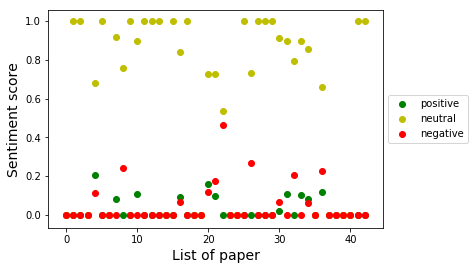

In [15]:
x = np.arange(len(df_sentiment))
df_sentiment['compound']

#plt.close()
#comp = plt.scatter(x,df_sentiment['compound'])
pos = plt.scatter(x,df_sentiment['pos'], color = 'g')
neu = plt.scatter(x,df_sentiment['neu'], color = 'y')
neg = plt.scatter(x,df_sentiment['neg'], color = 'r')

plt.legend((pos, neu, neg),('positive', 'neutral','negative'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("List of paper", fontsize=14)
plt.ylabel("Sentiment score", fontsize=14)

plt.savefig("sentiment.png")
plt.show()
